# Create figures for manuscript

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

import rpy2
from rpy2.robjects.packages import importr

import os
import sys
import glob
import pickle
import pandas as pd
import numpy as np
import rpy2.robjects.lib.ggplot2 as ggplot2
from plotnine import (ggplot,
                      labs,  
                      geom_line, 
                      geom_point,
                      geom_errorbar,
                      aes, 
                      ggsave, 
                      theme_bw,
                      theme,
                      facet_wrap,
                      scale_color_manual,
                      guides, 
                      guide_legend,
                      element_blank,
                      element_text,
                      element_rect,
                      element_line,
                      coords)
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings(action='ignore')

from numpy.random import seed
randomState = 123
seed(randomState)

/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/rpy2/robjects/lib/ggplot2.py:67: UserWarning: This was designed againt ggplot2 version 2.2.0 but you have 3.2.1
  warnings.warn('This was designed againt ggplot2 version %s but you have %s' % (TARGET_VERSION, ggplot2.__version__))


## Load data

In [2]:
# File directories
base_dir = os.path.abspath(
  os.path.join(
      os.getcwd(), "../..")) 

similarity_uncorrected_file = os.path.join(
    base_dir,
    "results",
    "saved_variables",
    "analysis_3_similarity_uncorrected.pickle")

ci_uncorrected_file = os.path.join(
    base_dir,
    "results",
    "saved_variables",
    "analysis_3_ci_uncorrected.pickle")

similarity_corrected_file = os.path.join(
    base_dir,
    "results",
    "saved_variables",
    "analysis_3_similarity_corrected.pickle")

ci_corrected_file = os.path.join(
    base_dir,
    "results",
    "saved_variables",
    "analysis_3_ci_corrected.pickle")

permuted_score_file = os.path.join(
    base_dir,
    "results",
    "saved_variables",
    "analysis_3_permuted.npy")

# locally stored simulated compendia files
local_dir = "/home/alexandra/Documents/"

compendia_dir = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "partition_simulated",
    "analysis_3")

In [3]:
# Output files
svcca_file = os.path.join(
    base_dir,
    "results",
    "analysis_3_svcca.svg")

pca_uncorrected_file = os.path.join(
    base_dir,
    "results",
    "analysis_3_pca_uncorrected.png")

pca_corrected_file = os.path.join(
    base_dir,
    "results",
    "analysis_3_pca_corrected.png")

In [4]:
# Load pickled files
uncorrected_svcca = pd.read_pickle(similarity_uncorrected_file)
err_uncorrected_svcca = pd.read_pickle(ci_uncorrected_file)
corrected_svcca = pd.read_pickle(similarity_corrected_file)
err_corrected_svcca = pd.read_pickle(ci_corrected_file)

permuted_score = np.load(permuted_score_file)

In [5]:
# Concatenate error bars
uncorrected_svcca_err = pd.concat([uncorrected_svcca, err_uncorrected_svcca], axis=1)
corrected_svcca_err = pd.concat([corrected_svcca, err_corrected_svcca], axis=1)

In [6]:
# Add group label
uncorrected_svcca_err['Group'] = 'uncorrected'
corrected_svcca_err['Group'] = 'corrected'

In [7]:
# Concatenate dataframes
all_svcca = pd.concat([uncorrected_svcca_err, corrected_svcca_err])
all_svcca

,score,ymin,ymax,Group
number of partitions,,,,
1,0.999974,0.999966,0.999982,uncorrected
2,0.928094,0.915746,0.940442,uncorrected
3,0.846421,0.839354,0.853489,uncorrected
5,0.733450,0.724369,0.742530,uncorrected
10,0.614763,0.606346,0.623181,uncorrected
20,0.715160,0.694823,0.735497,uncorrected
30,0.713450,0.684599,0.742300,uncorrected
50,0.775213,0.755191,0.795236,uncorrected
1,0.999981,0.999979,0.999983,corrected


## SVCCA panel

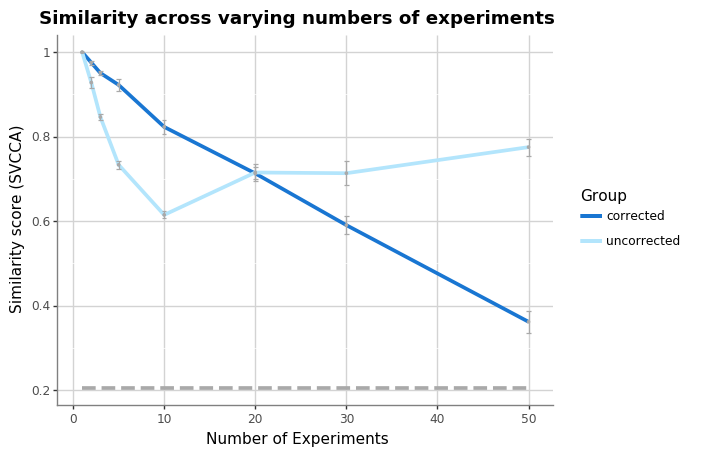

<ggplot: (-9223363256492205431)>


In [8]:
# Plot
lst_num_experiments = list(all_svcca.index)

threshold = pd.DataFrame(
    pd.np.tile(
        permuted_score,
        (len(lst_num_experiments), 1)),
    index=lst_num_experiments,
    columns=['score'])

panel_A = ggplot(all_svcca) \
    + geom_line(all_svcca,
                aes(x=lst_num_experiments, y='score', color='Group'),
                size=1.5) \
    + geom_point(aes(x=lst_num_experiments, y='score'), 
                 color ='darkgrey',
                size=0.5) \
    + geom_errorbar(all_svcca,
                  aes(x=lst_num_experiments, ymin='ymin', ymax='ymax'),
                   color='darkgrey') \
    + geom_line(threshold, 
                aes(x=lst_num_experiments, y='score'), 
                linetype='dashed',
                size=1.5,
                color="darkgrey",
                show_legend=False) \
    + labs(x = "Number of Experiments", 
           y = "Similarity score (SVCCA)", 
           title = "Similarity across varying numbers of experiments") \
    + theme(plot_title=element_text(weight='bold'),
            plot_background=element_rect(fill="white"),
            panel_background=element_rect(fill="white"),
            panel_grid_major_x=element_line(color="lightgrey"),
            panel_grid_major_y=element_line(color="lightgrey"),
            axis_line=element_line(color="grey"),
            legend_key=element_rect(fill='white', colour='white')
           ) \
    + scale_color_manual(['#1976d2', '#b3e5fc'])

print(panel_A)
ggsave(plot=panel_A, filename=svcca_file, device="svg", dpi=300)

## Uncorrected PCA panel

In [9]:
lst_num_experiments = [1, 2, 3, 5, 10, 20,
                    30, 50]

all_data_df = pd.DataFrame()

# Get batch 1 data
experiment_1_file = os.path.join(
    compendia_dir,
    "Partition_1_0.txt.xz")

experiment_1 = pd.read_table(
    experiment_1_file,
    header=0,
    index_col=0,
    sep='\t')


for i in lst_num_experiments:
    print('Plotting PCA of 1 partition vs {} partitions...'.format(i))
    
    # Simulated data with all samples in a single batch
    original_data_df =  experiment_1.copy()
    
    # Add grouping column for plotting
    original_data_df['num_experiments'] = '1'
    
    # Get data with additional batch effects added
    experiment_other_file = os.path.join(
        compendia_dir,
        "Partition_"+str(i)+"_0.txt.xz")

    experiment_other = pd.read_table(
        experiment_other_file,
        header=0,
        index_col=0,
        sep='\t')
    
    # Simulated data with i batch effects
    experiment_data_df =  experiment_other
    
    # Add grouping column for plotting
    experiment_data_df['num_experiments'] = 'multiple'
    
    # Concatenate datasets together
    combined_data_df = pd.concat([original_data_df, experiment_data_df])

    # PCA projection
    pca = PCA(n_components=2)

    # Encode expression data into 2D PCA space
    combined_data_numeric_df = combined_data_df.drop(['num_experiments'], axis=1)
    combined_data_PCAencoded = pca.fit_transform(combined_data_numeric_df)


    combined_data_PCAencoded_df = pd.DataFrame(combined_data_PCAencoded,
                                               index=combined_data_df.index,
                                               columns=['PC1', 'PC2']
                                              )
                                              
    # Variance explained
    print(pca.explained_variance_ratio_)  
    
    # Add back in batch labels (i.e. labels = "batch_"<how many batch effects were added>)
    combined_data_PCAencoded_df['num_experiments'] = combined_data_df['num_experiments']
    
    # Add column that designates which batch effect comparision (i.e. comparison of 1 batch vs 5 batches
    # is represented by label = 5)
    combined_data_PCAencoded_df['comparison'] = str(i)
    
    # Concatenate ALL comparisons
    all_data_df = pd.concat([all_data_df, combined_data_PCAencoded_df])     

Plotting PCA of 1 partition vs 1 partitions...
[0.50224137 0.12369031]
Plotting PCA of 1 partition vs 2 partitions...
[0.36184068 0.19833647]
Plotting PCA of 1 partition vs 3 partitions...
[0.34545544 0.16427224]
Plotting PCA of 1 partition vs 5 partitions...
[0.33655329 0.15022301]
Plotting PCA of 1 partition vs 10 partitions...
[0.33387549 0.09799466]
Plotting PCA of 1 partition vs 20 partitions...
[0.34171311 0.10324678]
Plotting PCA of 1 partition vs 30 partitions...
[0.33191838 0.09272814]
Plotting PCA of 1 partition vs 50 partitions...
[0.32909202 0.09290093]


In [10]:
# Convert 'num_experiments' into categories to preserve the ordering
lst_num_experiments_str = [str(i) for i in lst_num_experiments]
num_experiments_cat = pd.Categorical(all_data_df['num_experiments'], categories=['1', 'multiple'])

# Convert 'comparison' into categories to preserve the ordering
comparison_cat = pd.Categorical(all_data_df['comparison'], categories=lst_num_experiments_str)

# Assign to a new column in the df
all_data_df = all_data_df.assign(num_experiments_cat = num_experiments_cat)
all_data_df = all_data_df.assign(comparison_cat = comparison_cat)

In [11]:
all_data_df.columns = ['PC1', 'PC2', 'num_experiments', 'comparison', 'No. of partitions', 'Comparison']

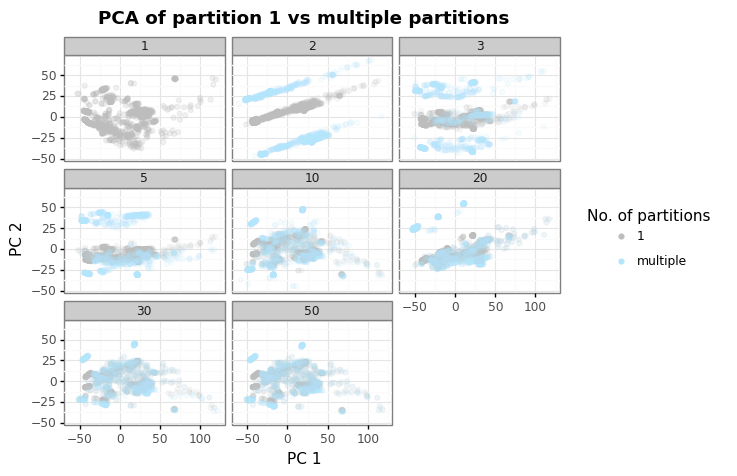

<ggplot: (-9223363256498251723)>


In [12]:
# Plot all comparisons in one figure
panel_B = ggplot(all_data_df[all_data_df['Comparison'] != '1'],
                 aes(x='PC1', y='PC2')) \
    + geom_point(aes(color='No. of partitions'), 
                 alpha=0.1) \
    + facet_wrap('~Comparison') \
    + labs(x = "PC 1", 
           y = "PC 2", 
           title = "PCA of partition 1 vs multiple partitions") \
    + theme_bw() \
    + theme(
        legend_title_align = "center",
        plot_background=element_rect(fill='white'),
        legend_key=element_rect(fill='white', colour='white'), 
        plot_title=element_text(weight='bold')
    ) \
    + guides(colour=guide_legend(override_aes={'alpha': 1})) \
    + scale_color_manual(['#bdbdbd', '#b3e5fc']) \
    + geom_point(data=all_data_df[all_data_df['Comparison'] == '1'],
                 alpha=0.1, 
                 color='#bdbdbd')

print(panel_B)
ggsave(plot=panel_B, filename=pca_uncorrected_file, dpi=500)

## Corrected PCA panel

In [13]:
lst_num_experiments = [1, 2, 3, 5, 10, 20,
                    30, 50]

all_corrected_data_df = pd.DataFrame()

# Get batch 1 data
experiment_1_file = os.path.join(
    compendia_dir,
    "Partition_corrected_1_0.txt.xz")

experiment_1 = pd.read_table(
    experiment_1_file,
    header=0,
    index_col=0,
    sep='\t')

# Transpose data to df: sample x gene
experiment_1 = experiment_1.T

for i in lst_num_experiments:
    print('Plotting PCA of 1 partition vs {} partitions...'.format(i))
    
     # Simulated data with all samples in a single batch
    original_data_df =  experiment_1.copy()
    
    # Match format of column names in before and after df
    original_data_df.columns = original_data_df.columns.astype(str)
    
    # Add grouping column for plotting
    original_data_df['num_experiments'] = '1'
    
    # Get data with additional batch effects added and corrected
    experiment_other_file = os.path.join(
        compendia_dir,
        "Partition_corrected_"+str(i)+"_0.txt.xz")

    experiment_other = pd.read_table(
        experiment_other_file,
        header=0,
        index_col=0,
        sep='\t')
    
    # Transpose data to df: sample x gene
    experiment_data_df = experiment_other.T
    
    # Add grouping column for plotting
    experiment_data_df['num_experiments'] = 'multiple'
    
    # Match format of column names in before and after df
    experiment_data_df.columns = original_data_df.columns
        
    # Concatenate datasets together
    combined_data_df = pd.concat([original_data_df, experiment_data_df])
    
    # PCA projection
    pca = PCA(n_components=2)

    # Encode expression data into 2D PCA space    
    combined_data_numeric_df = combined_data_df.drop(['num_experiments'], axis=1)    
    combined_data_PCAencoded = pca.fit_transform(combined_data_numeric_df)

    
    combined_data_PCAencoded_df = pd.DataFrame(combined_data_PCAencoded,
                                               index=combined_data_df.index,
                                               columns=['PC1', 'PC2']
                                              )
    
    # Add back in batch labels (i.e. labels = "batch_"<how many batch effects were added>)
    combined_data_PCAencoded_df['num_experiments'] = combined_data_df['num_experiments']
    
    # Add column that designates which batch effect comparision (i.e. comparison of 1 batch vs 5 batches
    # is represented by label = 5)
    combined_data_PCAencoded_df['comparison'] = str(i)
    
    # Concatenate ALL comparisons
    all_corrected_data_df = pd.concat([all_corrected_data_df, combined_data_PCAencoded_df])

Plotting PCA of 1 partition vs 1 partitions...
Plotting PCA of 1 partition vs 2 partitions...
Plotting PCA of 1 partition vs 3 partitions...
Plotting PCA of 1 partition vs 5 partitions...
Plotting PCA of 1 partition vs 10 partitions...
Plotting PCA of 1 partition vs 20 partitions...
Plotting PCA of 1 partition vs 30 partitions...
Plotting PCA of 1 partition vs 50 partitions...


In [14]:
# Convert 'num_experiments' into categories to preserve the ordering
lst_num_experiments_str = [str(i) for i in lst_num_experiments]
num_experiments_cat = pd.Categorical(all_corrected_data_df['num_experiments'], categories=['1', 'multiple'])

# Convert 'comparison' into categories to preserve the ordering
comparison_cat = pd.Categorical(all_corrected_data_df['comparison'], categories=lst_num_experiments_str)

# Assign to a new column in the df
all_corrected_data_df = all_corrected_data_df.assign(num_experiments_cat = num_experiments_cat)
all_corrected_data_df = all_corrected_data_df.assign(comparison_cat = comparison_cat)

In [15]:
all_corrected_data_df.columns = ['PC1', 'PC2', 'num_experiments', 'comparison', 'No. of partitions', 'Comparison']

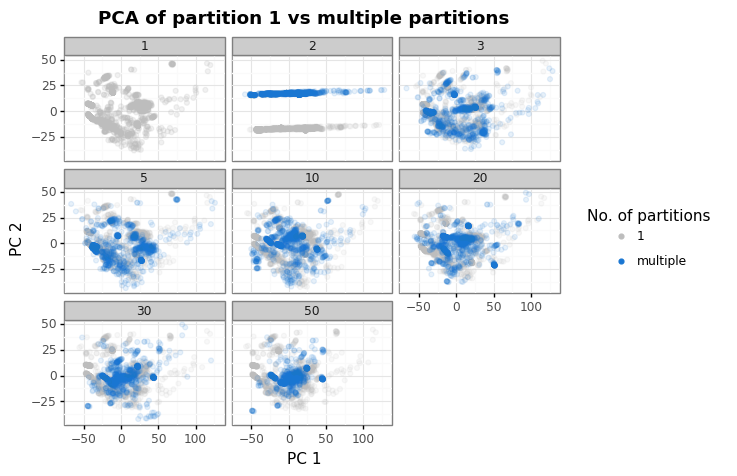

<ggplot: (8780361295687)>


In [16]:
# Plot all comparisons in one figure
panel_C = ggplot(all_corrected_data_df[all_corrected_data_df['Comparison'] != '1'],
                 aes(x='PC1', y='PC2')) \
    + geom_point(aes(color='No. of partitions'), 
                 alpha=0.1) \
    + facet_wrap('~Comparison') \
    + labs(x = "PC 1",
           y = "PC 2", 
           title = "PCA of partition 1 vs multiple partitions") \
    + theme_bw() \
    + theme(
        legend_title_align = "center",
        plot_background=element_rect(fill='white'),
        legend_key=element_rect(fill='white', colour='white'), 
        plot_title=element_text(weight='bold')
    )\
    + guides(colour=guide_legend(override_aes={'alpha': 1})) \
    + scale_color_manual(['#bdbdbd', '#1976d2']) \
    + geom_point(data=all_corrected_data_df[all_corrected_data_df['Comparison'] == '1'],
                 alpha=0.1, 
                 color='#bdbdbd')

print(panel_C)
ggsave(plot=panel_C, filename=pca_corrected_file, dpi=500)